In [46]:
#Import packages
import json, requests
import nltk
import re
from nltk.corpus import sentiwordnet as swn
import time
import timeit
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import datetime

In [47]:
CURRENCY = "bitcoin"
CURRENCY_SYMBOL = "BTC"
tweets_raw_file = f'data/twitter/{CURRENCY_SYMBOL}/{CURRENCY}_tweets_raw.csv'

In [49]:
#Remove the Duplicate ID rows to avoid getting same tweets
d = pd.read_csv(tweets_raw_file)
d.drop(0,inplace=True)
d.drop_duplicates('ID',inplace=True)
d = d.reset_index(drop=True)

In [50]:
#The total tweets number is
d.shape

(42801, 7)

In [51]:
d.head()

,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt
0,1256595810265051136,Become A #Bitcoin Developer: Basic 101 https:/...,Naked Wicks,22,0,0,Sat May 02 14:46:02 +0000 2020
1,1256595809077874688,⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...,CryptoSquawk,284,0,0,Sat May 02 14:46:01 +0000 2020
2,1256595805978284032,RT @lil_cryp: I'm embarrassed to say I shorted...,kjvbbnnn,0,5,0,Sat May 02 14:46:01 +0000 2020
3,1256595802736046081,RT @HuobiStats: #HPT Price USDT: 0.00588 (-0.4...,kim,67,27,0,Sat May 02 14:46:00 +0000 2020
4,1256595785719746560,"RT @CPSeduction: I’ll give 25,00$ #BTC or PayP...",edward,16,796,0,Sat May 02 14:45:56 +0000 2020


In [52]:
# Initialize NLTK's sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()
# create lists to append our sentiment scores too
sen = []
neg = []
neu = []
pos = []
com = []
# Iterate through all the post titles in our DataFrame
for sentence in d['Text']:
    sen.append(sentence)
    neg.append(list(sid.polarity_scores(sentence).values())[0])
    neu.append(list(sid.polarity_scores(sentence).values())[1])
    pos.append(list(sid.polarity_scores(sentence).values())[2])
    com.append(list(sid.polarity_scores(sentence).values())[3])
# convert all the lists to NumPy array's
sen = np.array(sen)
neg = np.array(neg)
neu = np.array(neu)
pos = np.array(pos)
com = np.array(com)
# create a DataFrame with all of our Sentiment Scores
df = pd.DataFrame({'ID': np.array(d['ID']),'Text' : sen, 'Negative' : neg, 'Neutral' : neu, 'Positive' : pos, 'Compound' : com})
df

,ID,Text,Negative,Neutral,Positive,Compound
0,1256595810265051136,Become A #Bitcoin Developer: Basic 101 https:/...,0.000,1.000,0.000,0.0000
1,1256595809077874688,⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...,0.185,0.630,0.185,0.0000
2,1256595805978284032,RT @lil_cryp: I'm embarrassed to say I shorted...,0.117,0.748,0.136,0.1027
3,1256595802736046081,RT @HuobiStats: #HPT Price USDT: 0.00588 (-0.4...,0.000,1.000,0.000,0.0000
4,1256595785719746560,"RT @CPSeduction: I’ll give 25,00$ #BTC or PayP...",0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...
42796,1256311626229264386,RT @SergheiPogor: 🏦 LITECOIN UPDATE!! CRITICAL...,0.208,0.792,0.000,-0.6371
42797,1256311622143930368,RT @100trillionUSD: Chart update: #Bitcoin hal...,0.000,1.000,0.000,0.0000
42798,1256311621950922753,@fiatleak why is #ltc even on the list. It is ...,0.246,0.754,0.000,-0.7346
42799,1256311607564500992,RT @cryptobrice: 25$ #BTC giveaway! 📌Follow me...,0.000,1.000,0.000,0.0000


In [54]:
#Merge the extracted sentiment score with tweetes dataframe
data = pd.merge(d,df,on=['ID'], how='left')
data.drop('Text_y',axis=1,inplace=True)

In [57]:
data[data['Positive']>=0.5]

,ID,Text_x,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,Negative,Neutral,Positive,Compound
2183,1256586683828654083,Good luck getting good pay at your next job. L...,"“Nicky""",1222,0,0,Sat May 02 14:09:46 +0000 2020,0.045,0.422,0.532,0.9325
4479,1256576318285676546,Saturday surprise incoming🥂🇺🇸#Bitcoin,White Collar Farmer,11,0,0,Sat May 02 13:28:34 +0000 2020,0.000,0.488,0.512,0.2732
5131,1256573944326471680,"Lol. #bitcoin solves this.""Trusted third parti...",⚡️Bitcoin Puerto Rico⚡,1404,0,0,Sat May 02 13:19:08 +0000 2020,0.000,0.375,0.625,0.8402
5796,1256571245556047872,Awesome list of #BITCOIN opportunities https:/...,oilfielder1,123,0,0,Sat May 02 13:08:25 +0000 2020,0.000,0.374,0.626,0.7717
6434,1256568692491481088,@troyrobins50 @novogratz A friend in Lebanon h...,Jackelon Duskey,16,0,0,Sat May 02 12:58:16 +0000 2020,0.000,0.465,0.535,0.8481
...,...,...,...,...,...,...,...,...,...,...,...
40299,1256328427243663361,I don't just like but in fact I love the prett...,Gideon Blessing Yang,2637,1,6,Fri May 01 21:03:33 +0000 2020,0.039,0.381,0.580,0.9758
40668,1256326251138039809,This is great 👍... enjoying @officialmcafee ;)...,Joshua b Smith,1936,0,0,Fri May 01 20:54:54 +0000 2020,0.000,0.480,0.520,0.8979
42037,1256317571655221249,"Best way to success, success await you through...",Isabella Anderson,1,0,1,Fri May 01 20:20:24 +0000 2020,0.000,0.409,0.591,0.9186
42206,1256316382632787969,Happy #Bitcoin Halving month. 🚀,Don Crrrrrrrypto - Khalil,866,0,2,Fri May 01 20:15:41 +0000 2020,0.000,0.448,0.552,0.5719


In [56]:
from transformers import pipeline

# Allocate a pipeline for sentiment-analysis
nlp = pipeline('sentiment-analysis')

  Using cached jmespath-0.9.5-py2.py3-none-any.whl (24 kB)
  Using cached s3transfer-0.3.3-py2.py3-none-any.whl (69 kB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893262 sha256=4580a8982e89c4fb541a63ae9d1fe59149ada24d73e6be2c02e7389ab6ab78ad
  Stored in directory: c:\users\ruturaj nene\appdata\local\pip\cache\wheels\49\25\98\cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses


Downloading: 100%|█████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 148kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 232k/232k [00:08<00:00, 28.0kB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 76.9kB/s]
Downloading: 100%|███████████████████████████████████████████████████████████████████| 268M/268M [16:01<00:00, 279kB/s]


In [59]:
t=data['Text_x']
t

0        Become A #Bitcoin Developer: Basic 101 https:/...
1        ⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...
2        RT @lil_cryp: I'm embarrassed to say I shorted...
3        RT @HuobiStats: #HPT Price USDT: 0.00588 (-0.4...
4        RT @CPSeduction: I’ll give 25,00$ #BTC or PayP...
                               ...                        
42796    RT @SergheiPogor: 🏦 LITECOIN UPDATE!! CRITICAL...
42797    RT @100trillionUSD: Chart update: #Bitcoin hal...
42798    @fiatleak why is #ltc even on the list. It is ...
42799    RT @cryptobrice: 25$ #BTC giveaway! 📌Follow me...
42800    RT @Nakazakihero: #DAPS soon will fly .#Btc ht...
Name: Text_x, Length: 42801, dtype: object

In [60]:
import time
sentiments = []

start = time.time()
for i in range(len(t)):
    sentiments.append(nlp(t[i]))
    if i % 100
    == 0:
        print(i, time.time() - start)
        start = time.time()

0 0.19354748725891113
100 14.688201665878296
200 15.366913318634033
300 15.949357271194458
400 15.091650485992432
500 19.191688776016235
600 13.44904351234436
700 14.49524712562561
800 13.732317686080933
900 13.912801742553711
1000 14.275833368301392
1100 14.268851041793823
1200 14.107284307479858
1300 13.948699474334717
1400 13.78314995765686
1500 14.12822699546814
1600 13.83999752998352
1700 14.064398050308228
1800 13.79511833190918
1900 15.550424575805664
2000 15.163459300994873
2100 13.909809589385986
2200 14.404489278793335
2300 13.562738418579102
2400 13.812072277069092
2500 13.724306106567383
2600 14.030488014221191
2700 14.085342407226562
2800 13.924770832061768
2900 13.801101446151733
3000 13.646514892578125
3100 13.625570058822632
3200 13.830018043518066
3300 13.550769329071045
3400 13.738268375396729
3500 14.287800550460815
3600 13.556755542755127
3700 13.722299337387085
3800 13.884878158569336
3900 13.734280109405518
4000 13.907815933227539
4100 14.479289293289185
4200 13.5

33500 14.019775629043579
33600 13.890366315841675
33700 14.057416915893555
33800 14.837329864501953
33900 15.003885507583618
34000 14.48427700996399
34100 13.828030586242676
34200 14.077363014221191
34300 14.147176027297974
34400 15.724950790405273
34500 14.60488247871399
34600 14.0464448928833
34700 14.541123867034912
34800 14.004021167755127
34900 14.296777486801147
35000 15.690051317214966
35100 14.753553867340088
35200 14.378556251525879
35300 14.119552850723267
35400 13.941720724105835
35500 13.908813714981079
35600 15.029815912246704
35700 14.518284559249878
35800 13.852963209152222
35900 14.180087327957153
36000 14.758543252944946
36100 13.958679437637329
36200 13.712340354919434
36300 13.809080839157104
36400 13.518855094909668
36500 14.217988014221191
36600 14.101300477981567
36700 13.595650911331177
36800 13.62357497215271
36900 17.0613853931427
37000 13.716330289840698
37100 13.787139415740967
37200 13.665464162826538
37300 15.616249561309814
37400 14.266855239868164
37500 1

In [76]:
sen = pd.DataFrame(sentiments, columns = ['sentiment-sentiment_score'])
sen

,sentiment-sentiment_score
0,"{'label': 'NEGATIVE', 'score': 0.99390596}"
1,"{'label': 'NEGATIVE', 'score': 0.9961034}"
2,"{'label': 'NEGATIVE', 'score': 0.99298203}"
3,"{'label': 'NEGATIVE', 'score': 0.99826866}"
4,"{'label': 'NEGATIVE', 'score': 0.99653226}"
...,...
42796,"{'label': 'NEGATIVE', 'score': 0.9819339}"
42797,"{'label': 'NEGATIVE', 'score': 0.9974716}"
42798,"{'label': 'NEGATIVE', 'score': 0.99976}"
42799,"{'label': 'NEGATIVE', 'score': 0.9843748}"


In [75]:
hour = data['CreatedAt'].map(lambda x:x.split(" ")[3].split(":")[0])
hr = pd.DataFrame(np.array(hour), columns = ['Hour'])
hr

,Hour
0,14
1,14
2,14
3,14
4,14
...,...
42796,19
42797,19
42798,19
42799,19


In [113]:
final_dataframe_txt_sent_hour = pd.concat([data, sen, hr], axis=1)

In [114]:
final_dataframe_txt_sent_hour.to_csv("final_dataframe_twitter_sent_hour", index=False)

In [115]:
final_dataframe_txt_sent_hour

,ID,Text_x,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,Negative,Neutral,Positive,Compound,sentiment-sentiment_score,hour1
0,1256595810265051136,Become A #Bitcoin Developer: Basic 101 https:/...,Naked Wicks,22,0,0,Sat May 02 14:46:02 +0000 2020,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99390596}",18
1,1256595809077874688,⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...,CryptoSquawk,284,0,0,Sat May 02 14:46:01 +0000 2020,0.185,0.630,0.185,0.0000,"{'label': 'NEGATIVE', 'score': 0.9961034}",19
2,1256595805978284032,RT @lil_cryp: I'm embarrassed to say I shorted...,kjvbbnnn,0,5,0,Sat May 02 14:46:01 +0000 2020,0.117,0.748,0.136,0.1027,"{'label': 'NEGATIVE', 'score': 0.99298203}",20
3,1256595802736046081,RT @HuobiStats: #HPT Price USDT: 0.00588 (-0.4...,kim,67,27,0,Sat May 02 14:46:00 +0000 2020,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99826866}",21
4,1256595785719746560,"RT @CPSeduction: I’ll give 25,00$ #BTC or PayP...",edward,16,796,0,Sat May 02 14:45:56 +0000 2020,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99653226}",22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42796,1256311626229264386,RT @SergheiPogor: 🏦 LITECOIN UPDATE!! CRITICAL...,Angela Peters,992,1,0,Fri May 01 19:56:47 +0000 2020,0.208,0.792,0.000,-0.6371,"{'label': 'NEGATIVE', 'score': 0.9819339}",NaN
42797,1256311622143930368,RT @100trillionUSD: Chart update: #Bitcoin hal...,WALL.BrrrrrEAKER,238,678,0,Fri May 01 19:56:46 +0000 2020,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9974716}",NaN
42798,1256311621950922753,@fiatleak why is #ltc even on the list. It is ...,Mujtaba Khan,90,0,0,Fri May 01 19:56:46 +0000 2020,0.246,0.754,0.000,-0.7346,"{'label': 'NEGATIVE', 'score': 0.99976}",NaN
42799,1256311607564500992,RT @cryptobrice: 25$ #BTC giveaway! 📌Follow me...,Tulip Al,41,1480,0,Fri May 01 19:56:43 +0000 2020,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9843748}",NaN


In [81]:
bitcoin = pd.read_csv('bitcoinity_data.csv')
bitcoin

,Time,price,volume
0,2020-04-30 18:00:00 UTC,8646.813799,5.276545e+07
1,2020-04-30 19:00:00 UTC,8794.153982,4.814522e+07
2,2020-04-30 20:00:00 UTC,8799.536927,3.391377e+07
3,2020-04-30 21:00:00 UTC,8806.861286,1.827702e+07
4,2020-04-30 22:00:00 UTC,8713.860537,2.378346e+07
...,...,...,...
162,2020-05-07 12:00:00 UTC,9323.994262,2.568088e+07
163,2020-05-07 13:00:00 UTC,9477.185445,1.207203e+08
164,2020-05-07 14:00:00 UTC,9512.784571,3.946468e+07
165,2020-05-07 15:00:00 UTC,9489.294244,5.630934e+07


In [94]:
#Generate the target labels
bitcoin['label']=bitcoin['price'][1:].reset_index(drop=True)

In [96]:
bitcoin.drop(166,inplace=True)

In [97]:
bitcoin

,Time,price,volume,label
0,2020-04-30 18:00:00 UTC,8646.813799,5.276545e+07,8794.153982
1,2020-04-30 19:00:00 UTC,8794.153982,4.814522e+07,8799.536927
2,2020-04-30 20:00:00 UTC,8799.536927,3.391377e+07,8806.861286
3,2020-04-30 21:00:00 UTC,8806.861286,1.827702e+07,8713.860537
4,2020-04-30 22:00:00 UTC,8713.860537,2.378346e+07,8665.210467
...,...,...,...,...
161,2020-05-07 11:00:00 UTC,9287.740666,1.063551e+07,9323.994262
162,2020-05-07 12:00:00 UTC,9323.994262,2.568088e+07,9477.185445
163,2020-05-07 13:00:00 UTC,9477.185445,1.207203e+08,9512.784571
164,2020-05-07 14:00:00 UTC,9512.784571,3.946468e+07,9489.294244


In [100]:
X = bitcoin

,Time,price,volume,label
0,2020-04-30 18:00:00 UTC,8646.813799,5.276545e+07,8794.153982
1,2020-04-30 19:00:00 UTC,8794.153982,4.814522e+07,8799.536927
2,2020-04-30 20:00:00 UTC,8799.536927,3.391377e+07,8806.861286
3,2020-04-30 21:00:00 UTC,8806.861286,1.827702e+07,8713.860537
4,2020-04-30 22:00:00 UTC,8713.860537,2.378346e+07,8665.210467
...,...,...,...,...
161,2020-05-07 11:00:00 UTC,9287.740666,1.063551e+07,9323.994262
162,2020-05-07 12:00:00 UTC,9323.994262,2.568088e+07,9477.185445
163,2020-05-07 13:00:00 UTC,9477.185445,1.207203e+08,9512.784571
164,2020-05-07 14:00:00 UTC,9512.784571,3.946468e+07,9489.294244


In [101]:
date12 = []
hour1 = []
price1 = []
label1 = []
volume1 = []
for i in range(len(X)):
    date12.append(X.Time[i][:10])
    hour1.append(X.Time[i][11:13])
    price1.append(X.price[i])
    label1.append(X.label[i])
    volume1.append(X.volume[i])
    
dt = pd.DataFrame(date12, columns = ['Date1'])
hr = pd.DataFrame(hour1, columns = ['hour1'])
pr = pd.DataFrame(price1, columns = ['price1'])
lb = pd.DataFrame(label1, columns = ['label1'])
vol = pd.DataFrame(volume1, columns= ['volume1'])
new_data = pd.concat([dt, hr, pr, lb, vol], axis=1)

In [102]:
new_data

,Date1,hour1,price1,label1,volume1
0,2020-04-30,18,8646.813799,8794.153982,5.276545e+07
1,2020-04-30,19,8794.153982,8799.536927,4.814522e+07
2,2020-04-30,20,8799.536927,8806.861286,3.391377e+07
3,2020-04-30,21,8806.861286,8713.860537,1.827702e+07
4,2020-04-30,22,8713.860537,8665.210467,2.378346e+07
...,...,...,...,...,...
161,2020-05-07,11,9287.740666,9323.994262,1.063551e+07
162,2020-05-07,12,9323.994262,9477.185445,2.568088e+07
163,2020-05-07,13,9477.185445,9512.784571,1.207203e+08
164,2020-05-07,14,9512.784571,9489.294244,3.946468e+07


In [103]:
new_data.to_csv("new_data1.csv", index=False)

In [116]:
final_dataframe_txt_sent_hour['CreatedAt'] = final_dataframe_txt_sent_hour['CreatedAt'].astype('datetime64[ns]')

In [127]:
final_dataframe_txt_sent_hour['Date']=final_dataframe_txt_sent_hour['CreatedAt'].map(lambda x:x.date().strftime('%Y-%m-%d'))

In [128]:
final_dataframe_txt_sent_hour

,ID,Text_x,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,Negative,Neutral,Positive,Compound,sentiment-sentiment_score,hour1,Date
0,1256595810265051136,Become A #Bitcoin Developer: Basic 101 https:/...,Naked Wicks,22,0,0,2020-05-02 14:46:02,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99390596}",18,2020-05-02
1,1256595809077874688,⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...,CryptoSquawk,284,0,0,2020-05-02 14:46:01,0.185,0.630,0.185,0.0000,"{'label': 'NEGATIVE', 'score': 0.9961034}",19,2020-05-02
2,1256595805978284032,RT @lil_cryp: I'm embarrassed to say I shorted...,kjvbbnnn,0,5,0,2020-05-02 14:46:01,0.117,0.748,0.136,0.1027,"{'label': 'NEGATIVE', 'score': 0.99298203}",20,2020-05-02
3,1256595802736046081,RT @HuobiStats: #HPT Price USDT: 0.00588 (-0.4...,kim,67,27,0,2020-05-02 14:46:00,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99826866}",21,2020-05-02
4,1256595785719746560,"RT @CPSeduction: I’ll give 25,00$ #BTC or PayP...",edward,16,796,0,2020-05-02 14:45:56,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99653226}",22,2020-05-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42796,1256311626229264386,RT @SergheiPogor: 🏦 LITECOIN UPDATE!! CRITICAL...,Angela Peters,992,1,0,2020-05-01 19:56:47,0.208,0.792,0.000,-0.6371,"{'label': 'NEGATIVE', 'score': 0.9819339}",NaN,2020-05-01
42797,1256311622143930368,RT @100trillionUSD: Chart update: #Bitcoin hal...,WALL.BrrrrrEAKER,238,678,0,2020-05-01 19:56:46,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9974716}",NaN,2020-05-01
42798,1256311621950922753,@fiatleak why is #ltc even on the list. It is ...,Mujtaba Khan,90,0,0,2020-05-01 19:56:46,0.246,0.754,0.000,-0.7346,"{'label': 'NEGATIVE', 'score': 0.99976}",NaN,2020-05-01
42799,1256311607564500992,RT @cryptobrice: 25$ #BTC giveaway! 📌Follow me...,Tulip Al,41,1480,0,2020-05-01 19:56:43,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9843748}",NaN,2020-05-01


In [129]:
final_dataframe_txt_sent_hour.loc[(final_dataframe_txt_sent_hour['Date'].isin(new_data['Date1']))]

,ID,Text_x,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,Negative,Neutral,Positive,Compound,sentiment-sentiment_score,hour1,Date
0,1256595810265051136,Become A #Bitcoin Developer: Basic 101 https:/...,Naked Wicks,22,0,0,2020-05-02 14:46:02,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99390596}",18,2020-05-02
1,1256595809077874688,⬆️⬆️ $BTC BUYING PRESSURE ALERT 📈 Price tradin...,CryptoSquawk,284,0,0,2020-05-02 14:46:01,0.185,0.630,0.185,0.0000,"{'label': 'NEGATIVE', 'score': 0.9961034}",19,2020-05-02
2,1256595805978284032,RT @lil_cryp: I'm embarrassed to say I shorted...,kjvbbnnn,0,5,0,2020-05-02 14:46:01,0.117,0.748,0.136,0.1027,"{'label': 'NEGATIVE', 'score': 0.99298203}",20,2020-05-02
3,1256595802736046081,RT @HuobiStats: #HPT Price USDT: 0.00588 (-0.4...,kim,67,27,0,2020-05-02 14:46:00,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99826866}",21,2020-05-02
4,1256595785719746560,"RT @CPSeduction: I’ll give 25,00$ #BTC or PayP...",edward,16,796,0,2020-05-02 14:45:56,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99653226}",22,2020-05-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42796,1256311626229264386,RT @SergheiPogor: 🏦 LITECOIN UPDATE!! CRITICAL...,Angela Peters,992,1,0,2020-05-01 19:56:47,0.208,0.792,0.000,-0.6371,"{'label': 'NEGATIVE', 'score': 0.9819339}",NaN,2020-05-01
42797,1256311622143930368,RT @100trillionUSD: Chart update: #Bitcoin hal...,WALL.BrrrrrEAKER,238,678,0,2020-05-01 19:56:46,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9974716}",NaN,2020-05-01
42798,1256311621950922753,@fiatleak why is #ltc even on the list. It is ...,Mujtaba Khan,90,0,0,2020-05-01 19:56:46,0.246,0.754,0.000,-0.7346,"{'label': 'NEGATIVE', 'score': 0.99976}",NaN,2020-05-01
42799,1256311607564500992,RT @cryptobrice: 25$ #BTC giveaway! 📌Follow me...,Tulip Al,41,1480,0,2020-05-01 19:56:43,0.000,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9843748}",NaN,2020-05-01


In [141]:
#Merge the data available for cryptocurrency change with available tweets
final = final_dataframe_txt_sent_hour.merge(new_data,how='inner',left_on=['Date','hour1'],right_on=['Date1','hour1'])

In [142]:
final.dropna()

,ID,Text_x,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,Negative,Neutral,Positive,Compound,sentiment-sentiment_score,hour1,Date,Date1,price1,label1,volume1
0,1256595810265051136,Become A #Bitcoin Developer: Basic 101 https:/...,Naked Wicks,22,0,0,2020-05-02 14:46:02,0.0,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.99390596}",18,2020-05-02,2020-05-02,8883.478305,8864.234766,2.487283e+07
1,1256595685605924866,RT @Bitsahara: 0.001 #BTC #Giveaway 🔸RT🔸Follow...,Sunthor17,9,426,0,2020-05-02 14:45:32,0.0,0.715,0.285,0.6580,"{'label': 'NEGATIVE', 'score': 0.9842949}",18,2020-05-02,2020-05-02,8883.478305,8864.234766,2.487283e+07
2,1256595591376715777,RT @ScottTRXWarrior: Im going to give someone ...,Earn,2769,1298,0,2020-05-02 14:45:10,0.0,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9952796}",18,2020-05-02,2020-05-02,8883.478305,8864.234766,2.487283e+07
3,1256595457947643904,Give away soon if your not in you can’t win. #...,Crypto Wiz Kid,185,0,0,2020-05-02 14:44:38,0.0,0.833,0.167,0.5859,"{'label': 'NEGATIVE', 'score': 0.99500275}",18,2020-05-02,2020-05-02,8883.478305,8864.234766,2.487283e+07
4,1256595336627286016,RT @Crypto_Guy_UK: $30 #BTC giveaway 3 hours h...,max#♥️♥️♥️,33,519,0,2020-05-02 14:44:09,0.0,1.000,0.000,0.0000,"{'label': 'NEGATIVE', 'score': 0.9970799}",18,2020-05-02,2020-05-02,8883.478305,8864.234766,2.487283e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,1256595596686827527,RT @catexofficial: Projects listed at CAT.EX c...,Irfanali,134,1002,0,2020-05-02 14:45:11,0.0,0.857,0.143,0.5423,"{'label': 'NEGATIVE', 'score': 0.97693336}",17,2020-05-02,2020-05-02,8975.601509,8883.478305,1.643103e+07
162,1256595459289886720,"RT @BuyTheDipz: Exactly,@Mashinsky for preside...",cey cey okoça,85,287,0,2020-05-02 14:44:38,0.0,0.782,0.218,0.6476,"{'label': 'POSITIVE', 'score': 0.9812132}",17,2020-05-02,2020-05-02,8975.601509,8883.478305,1.643103e+07
163,1256595358546907138,RT @2BSovereign: Episode Two is live: With @ho...,wintermute,340,5,0,2020-05-02 14:44:14,0.0,0.913,0.087,0.2960,"{'label': 'NEGATIVE', 'score': 0.9902302}",17,2020-05-02,2020-05-02,8975.601509,8883.478305,1.643103e+07
164,1256595256302276613,"RT @freebitco: New Month, New Contest, and a $...",abdedaim baassiss,21,9,0,2020-05-02 14:43:50,0.0,0.852,0.148,0.5093,"{'label': 'NEGATIVE', 'score': 0.9823189}",17,2020-05-02,2020-05-02,8975.601509,8883.478305,1.643103e+07


In [143]:
final.columns

Index(['ID', 'Text_x', 'UserName', 'UserFollowerCount', 'RetweetCount',
       'Likes', 'CreatedAt', 'Negative', 'Neutral', 'Positive', 'Compound',
       'sentiment-sentiment_score', 'hour1', 'Date', 'Date1', 'price1',
       'label1', 'volume1'],
      dtype='object')

In [144]:
X = final.drop(columns = ['ID', 'UserName', 'UserFollowerCount', 'RetweetCount',
       'Likes', 'CreatedAt', 'Negative', 'Neutral', 'Positive', 'Compound', 'Date1'])

In [148]:
X = X[['Text_x', 'Date', 'sentiment-sentiment_score', 'hour1', 'price1',
       'label1', 'volume1']]

In [151]:
X.rename(columns={'Text_x':'Sentence','hour1':'Hour'},inplace=True)

In [152]:
X

,Sentence,Date,sentiment-sentiment_score,Hour,price1,label1,volume1
0,Become A #Bitcoin Developer: Basic 101 https:/...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.99390596}",18,8883.478305,8864.234766,2.487283e+07
1,RT @Bitsahara: 0.001 #BTC #Giveaway 🔸RT🔸Follow...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9842949}",18,8883.478305,8864.234766,2.487283e+07
2,RT @ScottTRXWarrior: Im going to give someone ...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9952796}",18,8883.478305,8864.234766,2.487283e+07
3,Give away soon if your not in you can’t win. #...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.99500275}",18,8883.478305,8864.234766,2.487283e+07
4,RT @Crypto_Guy_UK: $30 #BTC giveaway 3 hours h...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9970799}",18,8883.478305,8864.234766,2.487283e+07
...,...,...,...,...,...,...,...
161,RT @catexofficial: Projects listed at CAT.EX c...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.97693336}",17,8975.601509,8883.478305,1.643103e+07
162,"RT @BuyTheDipz: Exactly,@Mashinsky for preside...",2020-05-02,"{'label': 'POSITIVE', 'score': 0.9812132}",17,8975.601509,8883.478305,1.643103e+07
163,RT @2BSovereign: Episode Two is live: With @ho...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9902302}",17,8975.601509,8883.478305,1.643103e+07
164,"RT @freebitco: New Month, New Contest, and a $...",2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9823189}",17,8975.601509,8883.478305,1.643103e+07


In [158]:
X['sentiment-sentiment_score'][0]

{'label': 'NEGATIVE', 'score': 0.99390596}

In [159]:
#Extract sentiments and respective score for each tweet
samples = {}
for i in range(len(X)):  
    temp = X['sentiment-sentiment_score'][i]
    if(temp['label'] == 'POSITIVE'):
        samples[i] = (1, temp['score'])
    else:
        samples[i] = (-1, temp['score'])
# print(samples)
data_label = pd.DataFrame.from_dict(samples, orient='index',columns=['Sentiment', 'score'])

In [165]:
data_label

,Sentiment,score
0,-1,0.993906
1,-1,0.984295
2,-1,0.995280
3,-1,0.995003
4,-1,0.997080
...,...,...
161,-1,0.976933
162,1,0.981213
163,-1,0.990230
164,-1,0.982319


In [166]:
X_new = pd.concat([X, data_label], axis=1)

In [167]:
X_new

,Sentence,Date,sentiment-sentiment_score,Hour,price1,label1,volume1,Sentiment,score
0,Become A #Bitcoin Developer: Basic 101 https:/...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.99390596}",18,8883.478305,8864.234766,2.487283e+07,-1,0.993906
1,RT @Bitsahara: 0.001 #BTC #Giveaway 🔸RT🔸Follow...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9842949}",18,8883.478305,8864.234766,2.487283e+07,-1,0.984295
2,RT @ScottTRXWarrior: Im going to give someone ...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9952796}",18,8883.478305,8864.234766,2.487283e+07,-1,0.995280
3,Give away soon if your not in you can’t win. #...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.99500275}",18,8883.478305,8864.234766,2.487283e+07,-1,0.995003
4,RT @Crypto_Guy_UK: $30 #BTC giveaway 3 hours h...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9970799}",18,8883.478305,8864.234766,2.487283e+07,-1,0.997080
...,...,...,...,...,...,...,...,...,...
161,RT @catexofficial: Projects listed at CAT.EX c...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.97693336}",17,8975.601509,8883.478305,1.643103e+07,-1,0.976933
162,"RT @BuyTheDipz: Exactly,@Mashinsky for preside...",2020-05-02,"{'label': 'POSITIVE', 'score': 0.9812132}",17,8975.601509,8883.478305,1.643103e+07,1,0.981213
163,RT @2BSovereign: Episode Two is live: With @ho...,2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9902302}",17,8975.601509,8883.478305,1.643103e+07,-1,0.990230
164,"RT @freebitco: New Month, New Contest, and a $...",2020-05-02,"{'label': 'NEGATIVE', 'score': 0.9823189}",17,8975.601509,8883.478305,1.643103e+07,-1,0.982319


In [168]:
#Save the final tweet
X_new.to_csv("X_new.csv", index=False)

In [169]:
DATA = X_new.drop(columns = ['sentiment-sentiment_score', 'Sentence'])
y1 = X_new["label1"]

In [170]:
DATA.head()

,Date,Hour,price1,label1,volume1,Sentiment,score
0,2020-05-02,18,8883.478305,8864.234766,2.487283e+07,-1,0.993906
1,2020-05-02,18,8883.478305,8864.234766,2.487283e+07,-1,0.984295
2,2020-05-02,18,8883.478305,8864.234766,2.487283e+07,-1,0.995280
3,2020-05-02,18,8883.478305,8864.234766,2.487283e+07,-1,0.995003
4,2020-05-02,18,8883.478305,8864.234766,2.487283e+07,-1,0.997080


In [171]:
X1 = DATA.drop(columns = ['Date', 'Hour', 'label1'])
X1.head()

,price1,volume1,Sentiment,score
0,8883.478305,2.487283e+07,-1,0.993906
1,8883.478305,2.487283e+07,-1,0.984295
2,8883.478305,2.487283e+07,-1,0.995280
3,8883.478305,2.487283e+07,-1,0.995003
4,8883.478305,2.487283e+07,-1,0.997080


In [175]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore
X_train, X_test, y_train, y_test = train_test_split(X1.values, y1.values, shuffle=False, test_size=0.2)

In [176]:
reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

MSE: 7615.756616948963
MAE: 59.08522158392787


In [177]:
normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score', 'label1']).apply(zscore)
X2 = pd.concat([normalized_data, X1['Sentiment'], X1['score']], axis=1)
# y2 = normalized_data['label1']
mean, std = DATA['label1'].mean(), DATA['label1'].std()
# X2 = X2.drop(columns = ['label1'])
X2.head()

,price1,volume1,Sentiment,score
0,0.165351,2.089891,-1,0.993906
1,0.165351,2.089891,-1,0.984295
2,0.165351,2.089891,-1,0.995280
3,0.165351,2.089891,-1,0.995003
4,0.165351,2.089891,-1,0.997080


In [178]:
X2['Label']=X2['volume1'][1:].reset_index(drop=True)

In [179]:
X2

,price1,volume1,Sentiment,score,Label
0,0.165351,2.089891,-1,0.993906,2.089891
1,0.165351,2.089891,-1,0.984295,2.089891
2,0.165351,2.089891,-1,0.995280,2.089891
3,0.165351,2.089891,-1,0.995003,2.089891
4,0.165351,2.089891,-1,0.997080,2.089891
...,...,...,...,...,...
161,1.805732,0.883433,-1,0.976933,0.883433
162,1.805732,0.883433,1,0.981213,0.883433
163,1.805732,0.883433,-1,0.990230,0.883433
164,1.805732,0.883433,-1,0.982319,0.883433


In [181]:
X2.drop(165,inplace=True)

In [182]:
X3 = X2.drop(columns =['Label'])
y3 = X2.Label

MSE: 0.9901712965379207
MAE: 0.7466559923759492


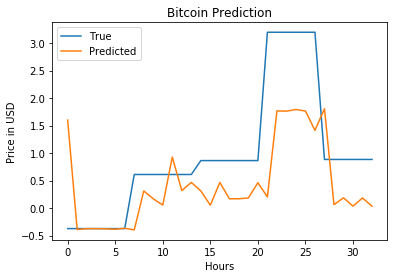

In [183]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)

reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train2, y_train2)
y_pred = reg.predict(X_test2)
print('MSE:', mean_squared_error(y_test2, y_pred))
print('MAE:', mean_absolute_error(y_test2, y_pred))

plt.plot(y_test2, label='True')
plt.plot(y_pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [184]:
y_pred_org = (y_pred * std) + mean
y_test_org = (y_test2 * std) + mean

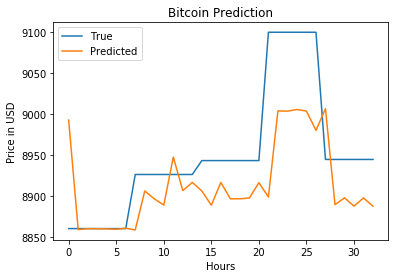

In [185]:
plt.plot(y_test_org, label='True')
plt.plot(y_pred_org, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [186]:
print('MSE:', mean_squared_error(y_test_org, y_pred_org))
print('MAE:', mean_absolute_error(y_test_org, y_pred_org))

MSE: 4478.023062358548
MAE: 50.21211924708079


In [187]:
# Applying LSTM
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)
X_train3.shape

(132, 4)

In [188]:
X_train3 = X_train3.reshape(X_train3.shape[0], 4 ,1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model1 = Sequential()
model1.add(LSTM(128, input_shape=(4,1),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(32, activation='tanh'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer="adam", loss="mean_squared_error")

model1.fit(X_train3, y_train3, epochs=50)

Train on 132 samples
Epoch 1/50
132/132 [==============================] - 2s 18ms/sample - loss: 0.6155
Epoch 2/50
132/132 [==============================] - 0s 302us/sample - loss: 0.4928
Epoch 3/50
132/132 [==============================] - 0s 325us/sample - loss: 0.3852
Epoch 4/50
132/132 [==============================] - 0s 280us/sample - loss: 0.3194
Epoch 5/50
132/132 [==============================] - 0s 370us/sample - loss: 0.3113
Epoch 6/50
132/132 [==============================] - 0s 287us/sample - loss: 0.2756
Epoch 7/50
132/132 [==============================] - 0s 325us/sample - loss: 0.2645
Epoch 8/50
132/132 [==============================] - 0s 332us/sample - loss: 0.2594
Epoch 9/50
132/132 [==============================] - 0s 317us/sample - loss: 0.2695
Epoch 10/50
132/132 [==============================] - 0s 348us/sample - loss: 0.2636
Epoch 11/50
132/132 [==============================] - 0s 295us/sample - loss: 0.2548
Epoch 12/50
132/132 [======================

MSE: 0.5177238717158369
MAE: 0.5020930884610352


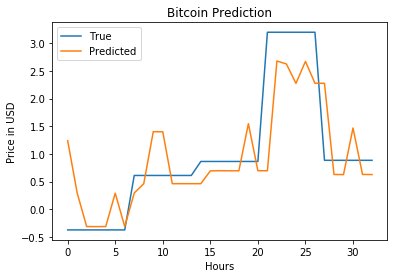

In [189]:
X_test3 = X_test2.reshape(X_test3.shape[0]*0.90, 4, 1)
y_pred3 = model1.predict(X_test3)
print('MSE:', mean_squared_error(y_test3, y_pred3))
print('MAE:', mean_absolute_error(y_test3, y_pred3))

plt.plot(y_test3, label='True')
plt.plot(y_pred3, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 2341.39288861601
MAE: 33.76550326998348


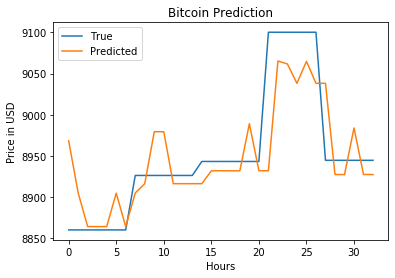

In [190]:
y_pred_org1 = (y_pred3 * std) + mean
y_test_org1 = (y_test3 * std) + mean
print('MSE:', mean_squared_error(y_test_org1, y_pred_org1))
print('MAE:', mean_absolute_error(y_test_org1, y_pred_org1))
plt.plot(y_test_org1, label='True')
plt.plot(y_pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 0.21095829372748046
MAE: 0.19211173468773274


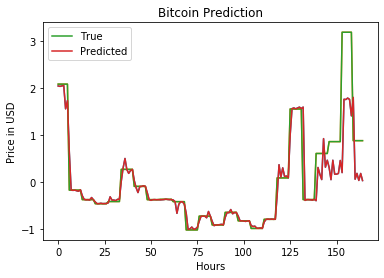

In [203]:
pred = reg.predict(X3)
plt.plot(pred)
plt.plot(y3)
print('MSE:', mean_squared_error(y3, pred))
print('MAE:', mean_absolute_error(y3, pred))
plt.plot(y3, label='True')
plt.plot(pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 954.0532106015128
MAE: 12.919386477041895


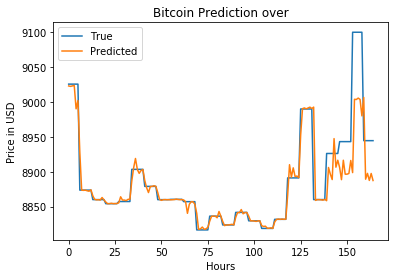

In [204]:
pred_org1 = (pred * std) + mean
y_org1 = (y3 * std) + mean
print('MSE:', mean_squared_error(y_org1, pred_org1))
print('MAE:', mean_absolute_error(y_org1, pred_org1))
plt.plot(y_org1, label='True')
plt.plot(pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over')
plt.legend()

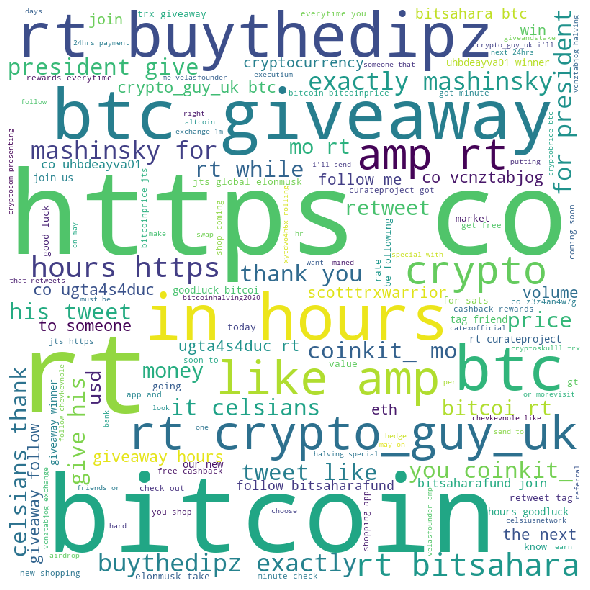

In [193]:
# Python program to generate WordCloud 
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
df = X_new["Sentence"]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
    # typecaste each val to string 
    val = str(val)   
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()